# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
# warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util, hypothesis_test

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [9]:
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig5/'
data_path = '/data/parameter_estimation/'

### Load the data

In [10]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [11]:
def simplify_name(name):
    return name.split('.')[0]

In [12]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')


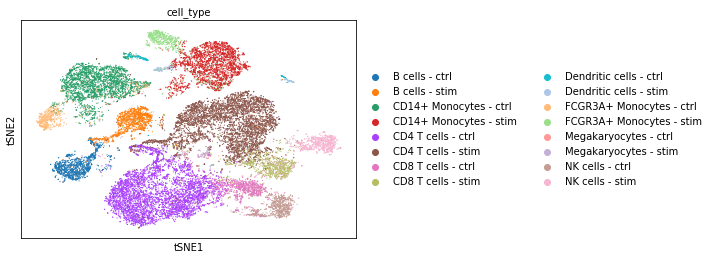

In [13]:
sc.pl.tsne(adata, color='cell_type')

In [14]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [15]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


In [16]:
with open(data_path + 'all_highcount_tfs.pkl', 'rb') as f:
	tfs = pkl.load(f)

### Change in correlation in response to IFN-B in all PBMCs

In [128]:
imp.reload(estimator)
imp.reload(hypothesis_test)
imp.reload(bootstrap)
imp.reload(scmemo)

adata_ct =  adata.copy()#adata[adata.obs.cell == 'B cells'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])
scmemo.create_groups(adata_ct, label_columns=['stim', 'ind'], inplace=True)

scmemo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True, use_n_umi=False, filter_mean_thresh=0.07, 
    min_perc_group=0.7)
print('Size of data', adata_ct.shape)

available_tfs = list(set(tfs) & set(adata_ct.var.index.tolist()))
target_genes = adata_ct.var.index.tolist()
print('TF list length', len(available_tfs))
scmemo.compute_2d_moments(adata_ct, available_tfs, target_genes)

Size of data (24495, 1861)
TF list length 29


In [129]:
%%time
scmemo.ht_2d_moments(
    adata_ct, 
    formula_like='1 + stim', 
    cov_column='stim', 
    num_cpus=6, 
    num_boot=10000)

# adata_ct.write(data_path + 'result_2d/stim_all_pbmc.h5ad')

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   12.7s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:   56.9s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 2580 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 3860 tasks      | elapsed: 30.3min
[Parallel(n_jobs=6)]: Done 4596 tasks      | elapsed: 34.8min
[Parallel(n_jobs=6)]: Done 5396 tasks      | elapsed: 40.0min
[Parallel(n_jobs=6)]: Done 6260 tasks      | elapsed: 48.8min
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed: 59.4min


CPU times: user 6min 32s, sys: 15 s, total: 6min 47s
Wall time: 7h 30min 16s


In [280]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

result_df = scmemo.get_2d_ht_result(adata_ct).dropna()

valid_counts = result_df.groupby('gene_1').size()
valid_tfs = valid_counts[valid_counts > 1300].index.tolist()

result_df = result_df.query('gene_1 in @valid_tfs')

mat = adata_ct.uns['scmemo']['2d_ht']['corr_coef'].T
mat = np.clip(mat, a_min=-0.6, a_max=.6)

heatmap_df = pd.DataFrame(mat, index=target_genes, columns=available_tfs)[valid_tfs].fillna(0.0)

1240


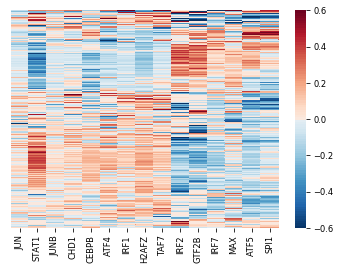

In [293]:
# Draw the heatmap
cg = sns.clustermap(
    heatmap_df[['JUN', 'STAT1','JUNB', 'CHD1','CEBPB', 'ATF4', 'IRF1', 'H2AFZ', 'TAF7', 'IRF2', 'GTF2B', 'IRF7', 'MAX','ATF5', 'SPI1']], 
    col_cluster=False
    );
cg.ax_row_dendrogram.set_visible(False)
col_order = ['JUN', 'STAT1','JUNB', 'CHD1','CEBPB', 'ATF4', 'IRF1', 'H2AFZ', 'TAF7', 'IRF2', 'GTF2B', 'IRF7', 'MAX','ATF5', 'SPI1']
row_order = cg.dendrogram_row.reordered_ind
plt.close()

select_rows = row_order[:int(len(row_order)/1.5)]
print(len(select_rows))
sns.heatmap(heatmap_df[col_order].iloc[select_rows, :], cmap=sns.color_palette("RdBu_r", 100)[:45] + sns.color_palette("RdBu_r", 100)[55:],yticklabels=[])

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


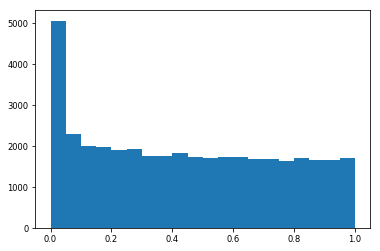

In [130]:
plt.hist(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel(), bins=20);

In [141]:
df.query('gene_1 == "STAT1" & corr_coef > -2 & corr_coef < 2').corr_coef.mean()

0.010226599654188387

In [135]:
df.query('corr_fdr < 0.1').sort_values('corr_coef', ascending=False).head(50)

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr
18613,STAT1,MRPL20,0.909577,3.341688e-03,0.083606
28223,SPI1,SSB,0.883439,2.521353e-07,0.000067
29728,SPI1,RTCB,0.864049,7.134436e-05,0.004027
19733,STAT1,CLNS1A,0.709423,1.471941e-03,0.049945
33806,ATF5,SSB,0.707945,1.394905e-04,0.006517
20323,STAT1,TECR,0.702543,2.667683e-03,0.072909
27915,SPI1,ISG15,0.701629,3.075095e-09,0.000008
28833,SPI1,LY6E,0.695263,7.509741e-07,0.000123
33498,ATF5,ISG15,0.667134,8.127173e-05,0.004452
28953,SPI1,IFITM2,0.629936,9.255773e-05,0.004905


### Compute 1D moments

In [19]:
adata_dict_pooled = {}
adata_dict = {}
for ct in cts:
    print(ct)
    adata_ct = adata[adata.obs.cell == ct].copy()
    adata_dict_pooled[ct] = scmemo.create_groups(adata_ct, label_columns=['stim'], inplace=False)
    adata_dict[ct] = scmemo.create_groups(adata_ct, label_columns=['stim', 'ind'], inplace=False)
    
    scmemo.compute_1d_moments(
        adata_dict_pooled[ct], inplace=True, filter_genes=True, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.05, 
        min_perc_group=0.4)
    
    scmemo.compute_1d_moments(
        adata_dict[ct], inplace=True, filter_genes=True, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.07, 
        min_perc_group=0.1)
    assert 'STAT1' in adata_dict_pooled[ct].var.index
    assert 'STAT1' in adata_dict[ct].var.index
    

CD4 T cells
CD14+ Monocytes
FCGR3A+ Monocytes
NK cells
CD8 T cells
B cells


### STAT1 correlations to rest of the transcriptome

In [694]:
stats.mannwhitneyu(stim_vals[np.isfinite(stim_vals)], ctrl_vals[np.isfinite(ctrl_vals)])

MannwhitneyuResult(statistic=4212593.0, pvalue=4.00519738099587e-38)

MannwhitneyuResult(statistic=4180693.0, pvalue=2.1348417745257044e-37)
MannwhitneyuResult(statistic=3650749.0, pvalue=4.791918136946987e-38)
MannwhitneyuResult(statistic=1834895.0, pvalue=9.85115478939952e-18)


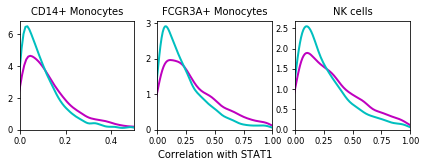

In [698]:
plt.figure(figsize=(7, 2))
ct_subset = ['CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells']
xlims = [0.5, 1, 1]

for idx, ct in enumerate(ct_subset):
    
    adata_ct = adata_dict_pooled[ct]
    scmemo.compute_2d_moments(adata_ct, ['STAT1'], adata_ct.var.index.tolist())
    plt.subplot(1, 3, idx+1)
    stim_vals = np.absolute(adata_ct.uns['scmemo']['2d_moments']['sg^stim']['corr'][0, :])
    ctrl_vals = np.absolute(adata_ct.uns['scmemo']['2d_moments']['sg^ctrl']['corr'][0, :])
    stim_vals[stim_vals == 1] = np.nan
    ctrl_vals[ctrl_vals == 1] = np.nan
    sns.distplot(stim_vals[np.isfinite(stim_vals)], color='m', hist=False, kde_kws={'lw':2})
    sns.distplot(ctrl_vals[np.isfinite(ctrl_vals)], color='c', hist=False, kde_kws={'lw':2})
    plt.xlim(0, xlims[idx])
    print(stats.mannwhitneyu(stim_vals[np.isfinite(stim_vals)],ctrl_vals[np.isfinite(ctrl_vals)] ))
    plt.title(ct)
    if ct == 'FCGR3A+ Monocytes':
        plt.xlabel('Correlation with STAT1')
plt.savefig(fig_path + 'stat1_correlations.pdf', bbox_inches='tight')

### STAT1 correlations to CHIP binding genes

In [22]:
conversion_df = pd.read_csv('conversion.csv')[['Transcript stable ID', 'Gene name']]
conversion_df.columns = ['transcript_id', 'gene_name']

In [177]:
# isgf3 genes
isgf3_df = pd.read_csv(data_path + 'chipseq/isgf3/isgf3_genes.bed', sep='\t', header=None).iloc[:, [-2, -1]]
isgf3_df.columns=['transcript_id', 'distance']
isgf3_df = isgf3_df.query('distance == 0')
isgf3_df = isgf3_df.merge(conversion_df, on='transcript_id', how='inner')
isgf3_genes = isgf3_df['gene_name'].drop_duplicates().tolist()

In [183]:
temp = adata.copy()#[adata.obs.stim == 'ctrl'].copy()
scmemo.create_groups(temp, label_columns=['ind'], inplace=True)
scmemo.compute_1d_moments(
    temp, inplace=True, filter_genes=True, 
    residual_var=True, use_n_umi=False, filter_mean_thresh=0.07, 
    min_perc_group=0.5)

In [186]:
isgf3_adata = scmemo.compute_2d_moments(
    temp, 
    ['STAT1', 'STAT2'],
    [g for g in isgf3_genes if g in temp.var.index], 
    inplace=False)
rest_adata = scmemo.compute_2d_moments(
    temp, 
    ['STAT1', 'STAT2'],
    [g for g in temp.var.index if g not in isgf3_genes], 
    inplace=False)

In [206]:
isgf3_df = []
for group in isgf3_adata.uns['scmemo']['groups']:
    df = pd.DataFrame()
    df['gene'] = [g for g in isgf3_genes if g in temp.var.index]
    df['ind'] = group.split('^')[-1]
    df['stat1_corr'] = isgf3_adata.uns['scmemo']['2d_moments'][group]['corr'][0, :]
    df['stat2_corr'] = isgf3_adata.uns['scmemo']['2d_moments'][group]['corr'][1, :]
    df['type'] = 'ISGF3'
    isgf3_df.append(df)
isgf3_df = pd.concat(isgf3_df)

rest_df = []
for group in rest_adata.uns['scmemo']['groups']:
    df = pd.DataFrame()
    df['gene'] = [g for g in temp.var.index if g not in isgf3_genes]
    df['ind'] = group.split('^')[-1]
    df['stat1_corr'] = rest_adata.uns['scmemo']['2d_moments'][group]['corr'][0, :]
    df['stat2_corr'] = rest_adata.uns['scmemo']['2d_moments'][group]['corr'][1, :]
    df['type'] = 'Rest'
    rest_df.append(df)
rest_df = pd.concat(rest_df)

# pval_dict = {}
for ind in isgf3_adata.obs.ind.drop_duplicates():
    
    a = isgf3_df.query('ind == "{}"'.format(ind))['stat1_corr'].values
    b = rest_df.query('ind == "{}"'.format(ind))['stat1_corr'].values    
    print('stat1', stats.mannwhitneyu(a[np.isfinite(a)], b[np.isfinite(b)]))
 
    a = isgf3_df.query('ind == "{}"'.format(ind))['stat2_corr'].values
    b = rest_df.query('ind == "{}"'.format(ind))['stat2_corr'].values    
    print('stat2', stats.mannwhitneyu(a[np.isfinite(a)], b[np.isfinite(b)]))

stat1 MannwhitneyuResult(statistic=31216.5, pvalue=1.0515597889719781e-32)
stat2 MannwhitneyuResult(statistic=38309.0, pvalue=7.136916909397161e-27)
stat1 MannwhitneyuResult(statistic=30998.5, pvalue=1.6210526223208024e-33)
stat2 MannwhitneyuResult(statistic=38857.5, pvalue=4.757315606937214e-27)
stat1 MannwhitneyuResult(statistic=30177.0, pvalue=2.04472713786996e-34)
stat2 MannwhitneyuResult(statistic=35462.5, pvalue=5.994502716251688e-30)
stat1 MannwhitneyuResult(statistic=41237.0, pvalue=7.493900831026455e-24)
stat2 MannwhitneyuResult(statistic=53733.0, pvalue=1.8241481761479514e-15)
stat1 MannwhitneyuResult(statistic=28468.0, pvalue=5.7042647103049996e-36)
stat2 MannwhitneyuResult(statistic=34113.0, pvalue=4.208815012543325e-31)
stat1 MannwhitneyuResult(statistic=38565.5, pvalue=2.395034947995044e-25)
stat2 MannwhitneyuResult(statistic=47647.0, pvalue=9.924570304982987e-19)
stat1 MannwhitneyuResult(statistic=30693.0, pvalue=7.714161468987456e-34)
stat2 MannwhitneyuResult(statistic=

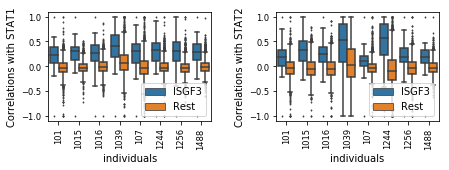

In [204]:
plt.figure(figsize=(7, 2))
combined_df = pd.concat([isgf3_df, rest_df])
plt.subplots_adjust(wspace=0.4)
# combined_df['sig_ind'] = combined_df['ind'].apply(lambda x: x if sig_dict[x] > 0.05 else x+'\n*')

plt.subplot(1, 2, 1)
sns.boxplot(x='ind', y='stat1_corr', hue='type', data=combined_df, fliersize=1)
plt.legend(loc='lower right')
plt.xlabel('individuals')
plt.ylabel('Correlations with STAT1')
plt.xticks(rotation=90)


plt.subplot(1, 2, 2)
sns.boxplot(x='ind', y='stat2_corr', hue='type', data=combined_df, fliersize=1)
plt.legend(loc='lower right')
plt.xlabel('individuals')
plt.ylabel('Correlations with STAT2')
plt.xticks(rotation=90)
plt.savefig(fig_path + 'isgf3_across_individuals.pdf', bbox_inches='tight')

### Gene examples

In [93]:
fdr = util._fdrcorrect(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel())

In [94]:
(fdr < 0.1).sum()

49

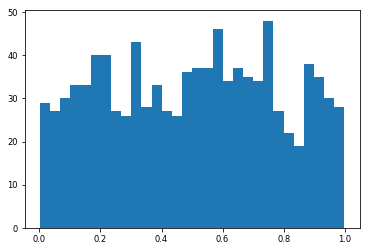

In [84]:
# not shuffed, CD14+ MOnocytes
plt.hist(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel(), bins=30);

In [ ]:
# not shuffed, all PBMC
plt.hist(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel(), bins=20);

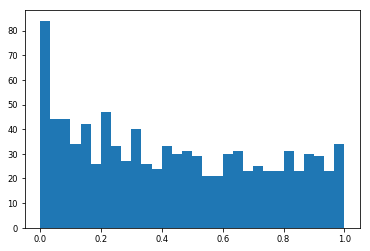

In [55]:
# shuffled :(
plt.hist(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel(), bins=30);

In [384]:
a1 = 6
a2 = 0.5
b1 = 100
b2 = 1
alpha = 1

In [408]:
alphas = np.linspace(-1, 1, 100)
original_diff = a1/np.sqrt(b1) - a2/np.sqrt(b2)
transformed_diff = (a1 - alphas)/np.sqrt(b1 + alphas) - (a2 - alphas)/np.sqrt(b2 + alphas)

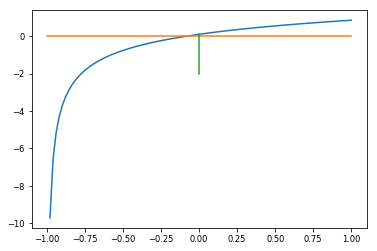

In [409]:
plt.plot(alphas, transformed_diff)
plt.plot([-1, 1], [0, 0])
plt.plot([0, 0], [-2, 0.1])

In [382]:
a1/np.sqrt(b1)

0.6

In [383]:
a2/np.sqrt(b2)

0.5

In [385]:
(a1+alpha)/np.sqrt(b1+alpha)

0.6965260331469925

In [386]:
(a2+alpha)/np.sqrt(b2+alpha)

1.0606601717798212

In [250]:
fdr = util._fdrcorrect(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel())

In [253]:
adata_ct.var.index[fdr < 0.15]

Index(['SSU72', 'HSPB11', 'BCAS2', 'NBPF10', 'SLAMF7', 'H3F3A', 'UNC50',
       'MFSD1', 'PPP1R2', 'ZCCHC10', 'TAF7', 'SMAP1', 'ATG5', 'SERINC1',
       'MKRN1', 'PIN4', 'TSC22D3', 'DOK2', 'COPS5', 'CYC1', 'DOCK8', 'ACTR1A',
       'SRSF9', 'LPAR6', 'RBM23', 'PSMA6', 'PSMC6', 'LGMN', 'IQGAP1',
       'TMEM208', 'CCL5', 'WDR83OS', 'MBOAT7'],
      dtype='object', name='index')

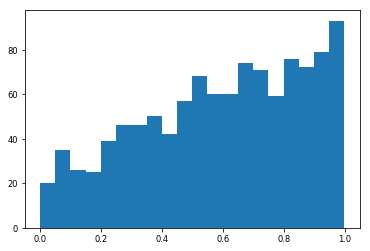

In [175]:
#30 bins
plt.hist(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel(), bins=20);

***

In [654]:
%%time
imp.reload(scmemo)
imp.reload(bootstrap)
imp.reload(estimator)
imp.reload(hypothesis_test)
imp.reload(util)
adata_ct = adata[adata.obs.cell == 'NK cells'].copy()
# test_adata.obs['stim'] = np.random.choice(test_adata.obs['stim'], test_adata.shape[0])
scmemo.create_groups(adata_ct, label_columns=['stim'], inplace=True)
scmemo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True, use_n_umi=False, filter_mean_thresh=0.05, 
    min_perc_group=0.4)
available_tfs = list(set(tfs) & set(adata_ct.var.index.tolist()))
available_tfs = ['STAT1']
target_genes = adata_ct.var.index.tolist()
scmemo.compute_2d_moments(adata_ct, available_tfs, target_genes)
print('Number of genes kept: {}'.format(adata_ct.shape[1]))
print('Number of TFs', len(available_tfs))
print('Number of target genes', len(target_genes))


Number of genes kept: 2517
Number of TFs 1
Number of target genes 2517
CPU times: user 781 ms, sys: 0 ns, total: 781 ms
Wall time: 1.01 s


(0, 0.6)

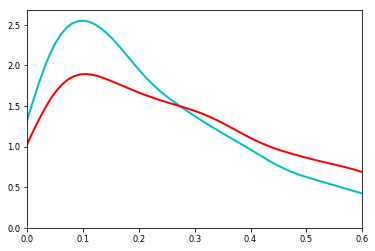

In [655]:

for group in adata_ct.uns['scmemo']['groups']:
    vals = np.absolute(adata_ct.uns['scmemo']['2d_moments'][group]['corr'][0, :])
    vals[vals == 1] = np.nan
    if 'stim' in group:
        sns.distplot(vals[np.isfinite(vals)], color='r', hist=False, kde_kws={'lw':2})
    if 'ctrl' in group:
        sns.distplot(vals[np.isfinite(vals)], color='c', hist=False, kde_kws={'lw':2})
plt.xlim(0, 0.6)


In [157]:
stat1_corr_df_list = []
for ct in cts:
    
    adata_ct = adata_dict_pooled[ct]
    scmemo.compute_2d_moments(adata_ct, ['STAT1'], adata_ct.var.index.tolist())

    stim_vals = adata_ct.uns['scmemo']['2d_moments']['sg^stim']['corr'][0, :]
    ctrl_vals = adata_ct.uns['scmemo']['2d_moments']['sg^ctrl']['corr'][0, :]
    diff = stim_vals - ctrl_vals
    
    df = pd.DataFrame()
    df['gene'] = adata_ct.var.index.tolist()
    df['mag_diff'] = diff
    df['ct'] = label_converter[ct]
    stat1_corr_df_list.append(df)
stat1_corr_df = pd.concat(stat1_corr_df_list)
stat1_corr_df['type'] = stat1_corr_df['gene'].apply(lambda x: 'ISGF3' if x in isgf3_genes else 'Rest')

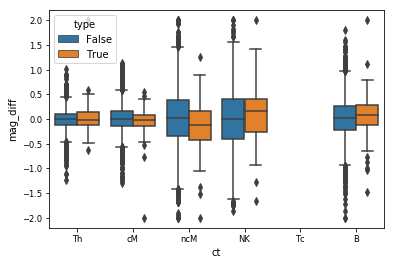

In [156]:
sns.boxplot(x='ct', y='mag_diff', hue='type', data=stat1_corr_df)
